In [14]:
!pip install requests beautifulsoup4 nltk textblob wordcloud scikit-learn imbalanced-learn pandas matplotlib seaborn


In [15]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
import pandas as pd
from textblob import TextBlob
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import joblib
from collections import Counter

In [16]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
url = "https://en.wikipedia.org/wiki/South_Africa"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
text = soup.get_text()

In [18]:
text = re.sub(r'\n+', ' ', text)
text = re.sub(r'\[\d+\]', '', text)
text = re.sub(r'[^a-zA-Z. ]', '', text)
text = re.sub(r'\s+', ' ', text).strip()

In [19]:
sentences = sent_tokenize(text)


In [20]:
def analyze_sentiment(sentence):
    return TextBlob(sentence).sentiment.polarity

df = pd.DataFrame(sentences, columns=["sentence"])
df["sentiment_score"] = df["sentence"].apply(analyze_sentiment)
df["sentiment"] = df["sentiment_score"].apply(lambda x: "positive" if x > 0 else ("negative" if x < 0 else "neutral"))

In [21]:
words = word_tokenize(text.lower())
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]

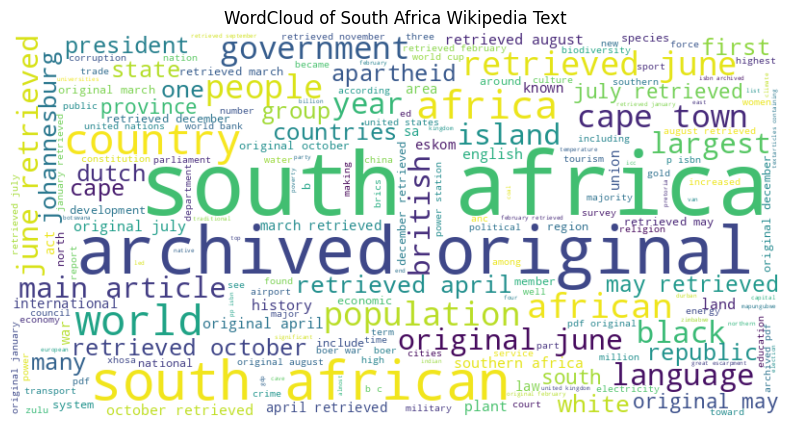

In [22]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of South Africa Wikipedia Text')
plt.show()

In [23]:
word_freq = Counter(filtered_words)
print("Top 10 frequent words:", word_freq.most_common(10))

Top 10 frequent words: [('south', 592), ('africa', 472), ('retrieved', 252), ('archived', 239), ('original', 230), ('african', 200), ('world', 102), ('cape', 100), ('june', 98), ('may', 80)]


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Only use positive and negative, but ensure both are present
df_binary = df[df['sentiment'] != 'neutral']

# Check if both classes are present after filtering
if df_binary['sentiment'].nunique() < 2:
    # Handle the case where only one class is present
    # This could involve adjusting data collection, preprocessing,
    # or choosing a different balancing technique for single-class scenarios.
    print("Warning: Only one class present after filtering. SMOTE cannot be applied.")
    # If only one sentiment is present, create dummy resampled data to avoid the error
    # This is a workaround and should be addressed by proper data balancing
    X_resampled, y_resampled = X, y # Assuming X and y are defined before this cell
else:
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df_binary['sentence'])
    y = df_binary['sentiment']

    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print("Balanced Class Distribution:", pd.Series(y_resampled).value_counts())

Balanced Class Distribution: sentiment
positive    620
negative    620
Name: count, dtype: int64


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Only use positive and negative, but ensure both are present
df_binary = df[df['sentiment'] != 'neutral']

# Check if both classes are present after filtering
if df_binary['sentiment'].nunique() < 2:
    # Handle the case where only one class is present
    # This could involve adjusting data collection, preprocessing,
    # or choosing a different balancing technique for single-class scenarios.
    print("Warning: Only one class present after filtering. SMOTE cannot be applied.")
    # If only one sentiment is present, create dummy resampled data to avoid the error
    # This is a workaround and should be addressed by proper data balancing
    X_resampled, y_resampled = X, y # Assuming X and y are defined before this cell
else:
    vectorizer = TfidfVectorizer()
    # Assign the results of fit_transform to X_binary
    X_binary = vectorizer.fit_transform(df_binary['sentence'])
    # Assign the sentiment column to y_binary
    y_binary = df_binary['sentiment']

    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_binary, y_binary)

    print("Balanced Class Distribution:", pd.Series(y_resampled).value_counts())

Balanced Class Distribution: sentiment
positive    620
negative    620
Name: count, dtype: int64


In [30]:
# 📊 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 🤖 Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("🔹 Logistic Regression Report")
print(classification_report(y_test, y_pred_log))


🔹 Logistic Regression Report
              precision    recall  f1-score   support

    negative       0.84      1.00      0.92       114
    positive       1.00      0.84      0.91       134

    accuracy                           0.92       248
   macro avg       0.92      0.92      0.92       248
weighted avg       0.93      0.92      0.92       248



In [31]:
# 🌳 Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("🔹 Decision Tree Report")
print(classification_report(y_test, y_pred_dt))


🔹 Decision Tree Report
              precision    recall  f1-score   support

    negative       0.83      0.95      0.89       114
    positive       0.95      0.84      0.89       134

    accuracy                           0.89       248
   macro avg       0.89      0.89      0.89       248
weighted avg       0.89      0.89      0.89       248



In [32]:
# 🌲 Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("🔹 Random Forest Report")
print(classification_report(y_test, y_pred_rf))

🔹 Random Forest Report
              precision    recall  f1-score   support

    negative       0.98      0.96      0.97       114
    positive       0.96      0.99      0.97       134

    accuracy                           0.97       248
   macro avg       0.97      0.97      0.97       248
weighted avg       0.97      0.97      0.97       248



In [33]:
# 💡 Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("🔹 Gradient Boosting Report")
print(classification_report(y_test, y_pred_gb))

🔹 Gradient Boosting Report
              precision    recall  f1-score   support

    negative       0.85      0.96      0.90       114
    positive       0.97      0.85      0.90       134

    accuracy                           0.90       248
   macro avg       0.91      0.91      0.90       248
weighted avg       0.91      0.90      0.90       248



In [34]:
# 🧮 Naive Bayes
X_train_nb = X_train.copy()
X_train_nb.data = X_train_nb.data.clip(min=0)
X_test_nb = X_test.copy()
X_test_nb.data = X_test_nb.data.clip(min=0)

nb = MultinomialNB()
nb.fit(X_train_nb, y_train)
y_pred_nb = nb.predict(X_test_nb)
print("🔹 Naive Bayes Report")
print(classification_report(y_test, y_pred_nb))

🔹 Naive Bayes Report
              precision    recall  f1-score   support

    negative       0.76      1.00      0.86       114
    positive       1.00      0.73      0.84       134

    accuracy                           0.85       248
   macro avg       0.88      0.87      0.85       248
weighted avg       0.89      0.85      0.85       248



In [35]:
# 🤝 KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("🔹 KNN Report")
print(classification_report(y_test, y_pred_knn))


🔹 KNN Report
              precision    recall  f1-score   support

    negative       0.58      1.00      0.74       114
    positive       1.00      0.39      0.56       134

    accuracy                           0.67       248
   macro avg       0.79      0.69      0.65       248
weighted avg       0.81      0.67      0.64       248



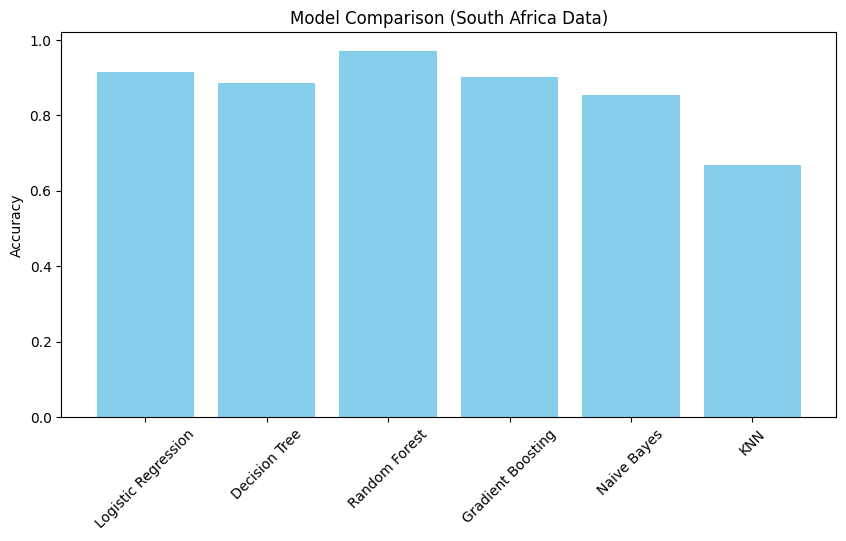

In [36]:
# 📊 Accuracy Comparison
models_accuracy = {
    "Logistic Regression": accuracy_score(y_test, y_pred_log),
    "Decision Tree": accuracy_score(y_test, y_pred_dt),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Gradient Boosting": accuracy_score(y_test, y_pred_gb),
    "Naive Bayes": accuracy_score(y_test, y_pred_nb),
    "KNN": accuracy_score(y_test, y_pred_knn)
}

plt.figure(figsize=(10, 5))
plt.bar(models_accuracy.keys(), models_accuracy.values(), color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Comparison (South Africa Data)")
plt.show()


In [39]:
# 💾 Save Final Model (Random Forest)
joblib.dump(rf, "random_forest_sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("\n✅ Model and vectorizer saved as 'random_forest_sentiment_model.pkl' and 'tfidf_vectorizer.pkl'")


✅ Model and vectorizer saved as 'random_forest_sentiment_model.pkl' and 'tfidf_vectorizer.pkl'


In [38]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
